# MXNet Basics - The basics of using linear regression as an example

In this tutorial, we will discuss some concepts that are fundamental to MXNet. Once familiar with these concepts, the user should be able to define and train simple neural networks in MXNet, and make predictions using the trained network.

Some of the concepts covered in this tutorial are:
 - **IO Class/Data Iterators** This is the MXNet internal class which handles data operations such as breaking the dataset into batches, shuffling the data and other such operations which are necessary to train a network.
 - **Symbols:** We define a network in MXNet by using Symbols. Symbols include placeholders for input data, model parameters, or any mathematical function that composes other Symbols together. Symbols can even represent entire layers of a neural network and loss functions to be optimized during training. Depending on what the Symbol is doing, these are some of the Symbol types:
        - Variables: Placeholders for future data
        - Neural Network Layer Symbols: Inbuilt layers of a neural network
        - Output Symbols: In-built symbols that implement different types of losses
 - **Module:** The module class in MXNet is used to fit a model (i.e. learn the parameters of the model based on the training data). The Module object gets associated with a specific Symbol (usually the loss Symbol) which it needs to minimize and also has parameters such as learning rate and optimization algorithm specified to it. After this, we feed the training data and labels to this object, using which it learns the model parameters.

## Implementation

In the next few sections, we will go through the details of implementing a simple model using MXNet.

## Task Definition and Imports

In this notebook, we're going to show you how to use MXNet to define and train a linear regression model. We will create a dataset which is approximately generated by this function:

y = x<sub>1</sub>  +  2x<sub>2</sub>,

and then allow the model to learn this function using only the generated datapoints. We will build the model using of MXNet, introducing the reader to its components like data-iterators, symbols and modules, and fit the model parameters to the data below.

In [2]:
import mxnet as mx
import numpy as np

#Training data
train_data = np.array([[1,2],[3,4],[5,6],[3,2],[7,1],[6,9]])
train_label = np.array([5.1,10.9,17.1,6.9,9.1,24])
batch_size = 1

#Evaluation Data
eval_data = np.array([[7,2],[6,10],[12,2]])
eval_label = np.array([11.1,25.9,16.2])


## Data Iterators - Preparing the data

We feed datasets to MXNet modules by packaging them up in objects called **Data Iterators**. The code below illustrates how to encode a dataset into an iterator that MXNet can use. Data iterators are useful because they take care of low level data operations such as batching, shuffling and bucketing, leaving the user free to concentrate on more of the modelling aspects.

There are several different types of data iterators available, based on the type of data we are working with. The data-type specific iterators provide preprocessing operations specific to the data we are dealing with. The user can also write his own iterator in MXNet if he finds the available iterators don't fulfil his needs. In our example, we will use the NDArrayIterator, which is used to iterate through Numpy NDArrays. More information on iterators can be found here:  http://mxnet.io/api/python/io.html

Once we have the data ready, we need to put it into an iterator and specify parameters such as the 'batch_size' and 'shuffle' which will determine the number of training examples the iterator feeds the model during each pass, and whether or not the data will be shuffled respectively.

In [36]:
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True, label_name='lin_reg_label') 
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False)

In the above example, batch_size is used to define the size of the batch the iterator generates for the model at each input, and if shuffle is set to true, the data fed to the iterator is shuffled before it is broken into batches.

## Symbols: Defining the Model Structure

MXNet uses **Symbols** for defining a model. Symbols are the building blocks of the model and compose various components of the model. Some of the parts symbols are used to define are:
1. Variables: A variable is a placeholder for data that will be provided in the future when we train the model.
2. Neural Network Layers: The layers of a network or any other type of model are also defined by Symbols. Such a symbol takes one of the previous symbols as its input, does some transformation on them, and creates an output. One such example is the "Fully Connected" symbol which specifies a fully connected layer of a network. 
3. Output Symbols: Output symbols are MXNet's way of defining a loss. They are suffixed with the word "Output" (eg. the SoftmaxOutput layer" . You can also create your own loss: https://github.com/dmlc/mxnet/blob/5b6a0eeee174f28ff0272d17748513ecd52a9ebe/docs/tutorials/r/CustomLossFunction.md#how-to-use-your-own-loss-function Some examples of existing losses are: LinearRegressionOutput, which computes the l2-loss between it's input symbol and the actual labels provided to it, SoftmaxOutput, which computes the categorical cross-entropy. 

The ones described above, and other symbols are chained one after the other, serving as input to one another to create the network topology. More information about the different types of symbols can be found at http://mxnet.io/api/python/symbol.html
    
    
   

In [29]:
# Defining the Model Structure

X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer  = mx.sym.FullyConnected(data=X, name='fc1', num_hidden = 1)
linear_regression_output = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name="linear_regression_output")

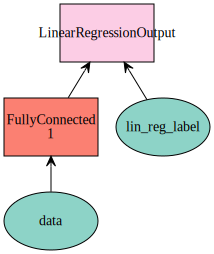

In [19]:
mx.viz.plot_network(symbol=linear_regression_output)

The above network uses the following layers:

1. FullyConnected: The fully connected symbol represents a fully connected layer of a neural network (without any activation being applied), which will be used as a linear transformation for our input data. It takes the following parameters:
            a. data: Input to the layer (specify the symbol whose output should be fed here)
            b. num_hidden: Number of hidden dimension which specifies the size of the output of the layer
    
    
2. Linear Regression Output: Output layers in MXNet aim at implementing a loss. In our example, the Linear Regression Output layer is used, which specifies that an l2 loss needs to be applied against its input and the actual labels provided to this layer. The parameters to this layer are:
            a. data: Input to this layer (specify the symbol whose output should be fed here)
            b. label: The training label against whom we will compare the input to the layer for calculation of l2 loss

**Note - *Naming Convention*: the label variable's name should be the same as the label_name parameter passed to your training data iterator. The default value of this is 'softmax_label', but we have updated it to lin_reg_label in this tutorial as you can see in Y = mx.symbol.Variable('lin_reg_label') and train_iter = mx.io.NDArrayIter(..., label_name="lin_reg_label")**

## Module: Training the model, Inference using the Model and Generating Test Metrix

The **Module** API is used to fit the model parameters to the data. While initializing the Module object, we provide it the symbol we want to minimize and the algorithm and learning rate to be used while training. After this, we call the fit function of the module class and pass the training iterator we created earlier to it, which it will use for learning the model parameters.

### Training the model

Here, we initialize the module object, passing to it the linear_regression_output variable defined earlier, which holds the loss function that we want to minimize.

In [37]:
model = mx.mod.Module(
    symbol = linear_regression_output ,
    data_names=['data'], 
    label_names = ['lin_reg_label']
)

Once we have defined the model structure, the next step is to fit the parameters of the model to the training data. This is done by using the **fit()** function of the **Module** class.

In [38]:
model.fit(train_iter, eval_iter,
            optimizer_params={'learning_rate':0.01},
            num_epoch=1000,
            batch_end_callback = mx.callback.Speedometer(batch_size, 2))

### Using a trained model: (Testing and Inference) 

Once we have a trained model, we can perform multiple operations using it. We can use it for inference, i.e predict output values for new inputs based on our learnt model. We can also evaluate the trained model on test data. These are shown below.

In [39]:
#Inference - predicting y for new unseen values of (x1, x2)
model.predict(eval_iter).asnumpy()

array([[ 11.07478809],
       [ 26.0716362 ],
       [ 16.13995743]], dtype=float32)

Here, our model was used to generate the predicted values based on the eval_iter iterator we created earlier, based on the parameters it has learnt.

We can also evaluate our model on some metric. In this example, we are evaluating our model's mean squared error on the evaluation data.

In [41]:
#Evaluation - Calculate metrics of how well our model is performing on unseen evaluation data
metric = mx.metric.MSE()
model.score(eval_iter, metric)

[('mse', 0.010104361766328415)]

Let us try to add some noise to the evaluation data and see how the MSE changes

In [10]:
#Evaluation Data
eval_data = np.array([[7,2],[6,10],[12,2]])
eval_label = np.array([14.1,27.1,19.1]) #Adding 0.1 to each of the values 
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False)

model.score(eval_iter, metric)

[('mse', 0.010000076144933701)]

Finally, you can create your own metrics and use it to evaluate your model. More information on metrics here: http://mxnet-test.readthedocs.io/en/latest/api/metric.html